# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting. We've implemented this in `libs/unet.py` module, and we will review it here.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [2]:
#!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
#!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
#!apt-get update -qq 2>&1 > /dev/null
#!apt-get -y install -qq google-drive-ocamlfuse fuse
#from google.colab import auth
#auth.authenticate_user()
#from oauth2client.client import GoogleCredentials
#creds = GoogleCredentials.get_application_default()
#import getpass
#!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
#vcode = getpass.getpass()
#!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#!cp -f ~/.gdfuse/default/config config
#!sed -i -e "s/^root_folder=$/root_folder=1guochIx5hAQvrZg20ult-PnKaONAPdm6/" config

#!mkdir -p drive
#!google-drive-ocamlfuse -config ./config -cc drive

import sys
sys.path.append('/content/drive/My Drive/PConvC')

import gc
from copy import deepcopy
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

from libs.util import random_mask
from libs.pconv_model import PConvUnet

# Settings
MAX_BATCH_SIZE = 128

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load the TensorBoard notebook extension
%load_ext tensorboard

Using TensorFlow backend.


In [0]:
!tar -zxvf "/content/drive/My Drive/PConvC/data/food-101.tar.gz" > /dev/null 2>&1 &

In [0]:
import os
import collections
from collections import defaultdict
import shutil

In [5]:

# Only split files if haven't already
if not os.path.isdir('/content/food-101/test') and not os.path.isdir('/content/food-101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food-101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food-101/images', 'food-101/test', ignore=ignore_train)
    copytree('food-101/images', 'food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

food-101/images
food-101/images/spring_rolls
food-101/images/poutine
food-101/images/club_sandwich
food-101/images/steak
food-101/images/chocolate_cake
food-101/images/macaroni_and_cheese
food-101/images/hamburger
food-101/images/panna_cotta
food-101/images/beet_salad
food-101/images/chicken_quesadilla
food-101/images/croque_madame
food-101/images/hot_dog
food-101/images/risotto
food-101/images/onion_rings
food-101/images/eggs_benedict
food-101/images/bruschetta
food-101/images/oysters
food-101/images/beignets
food-101/images/hummus
food-101/images/deviled_eggs
food-101/images/scallops
food-101/images/tacos
food-101/images/miso_soup
food-101/images/baby_back_ribs
food-101/images/hot_and_sour_soup
food-101/images/gnocchi
food-101/images/caesar_salad
food-101/images/waffles
food-101/images/ravioli
food-101/images/shrimp_and_grits
food-101/images/omelette
food-101/images/grilled_cheese_sandwich
food-101/images/paella
food-101/images/pork_chop
food-101/images/chocolate_mousse
food-101/imag

In [3]:
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask

from PIL import Image

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = "food-101/train"
#TEST_DIR = "drive/My Drive/PConvMC/data/hotcake1000/testfolder(hot)"
TEST_DIR = "drive/My Drive/PConvC/data/hotcake/testfolder2"
VAL_DIR = "food-101/test"
BATCH_SIZE = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            #mask1 = Image.open('/content/drive/My Drive/PConvC/data/pancake_mask3.jpg')
            
            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            
# Create training generator
train_datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(256, 256), batch_size=BATCH_SIZE
)
# Create validation generator
val_datagen = DataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(256, 256), batch_size=BATCH_SIZE, seed=1
)

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(256, 256), batch_size=BATCH_SIZE, seed=1
)

Found 1 images belonging to 1 classes.


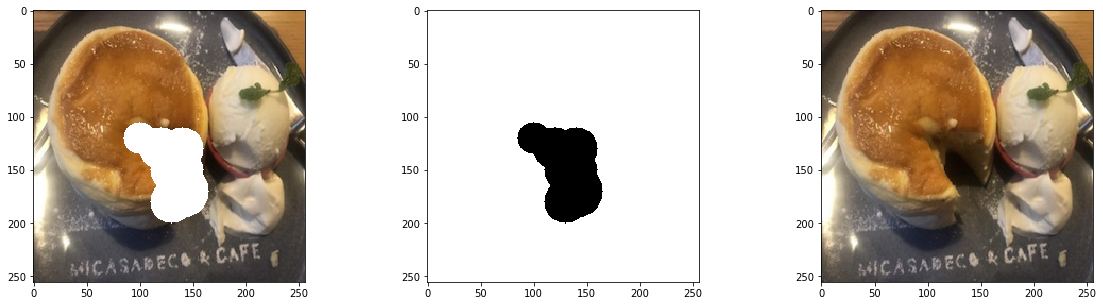

In [5]:

# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

In [0]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'/content/drive/My Drive/PConvC/data/hotcake/test_result/img_{}_{}.png'.format(i, pred_time))
        #plt.savefig(r'drive/My Drive/PConvC/data/test_result(hot1000)/img_{}_{}.png'.format(i, pred_time))
        plt.show()
        plt.close()

In [0]:
# Instantiate the model
model = PConvUnet(weight_filepath='/content/drive/My Drive/logs(hotmizumashi50000)/')
model.load('/content/drive/My Drive/logs(hotmizumashi50000)/22_weights_2020-01-22-19-50-40.h5')
#model = PConvUnet(weight_filepath='drive/My Drive/PConvC/data/logs(hot)/')
#model.load('drive/My Drive/PConvC/data/logs(hot)/575_weights_2020-01-03-11-22-20.h5')


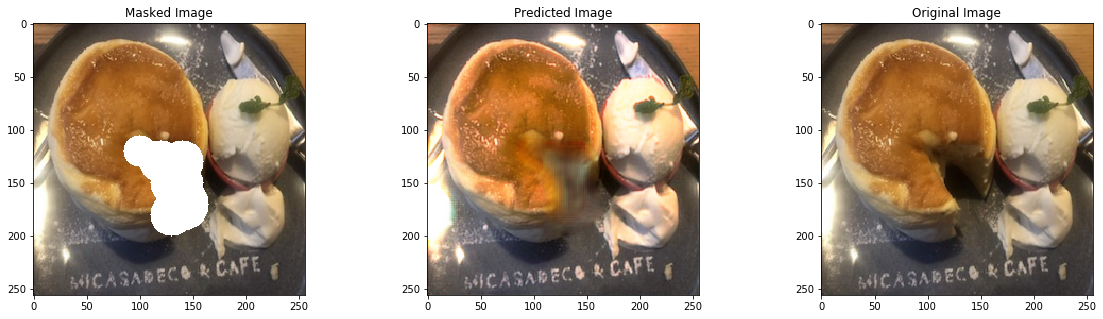

In [10]:
plot_callback(model)

In [0]:
#####テスト画像補完#####
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'drive/My Drive/PConvC/data/test_result(food101)/img_{}_{}.png'.format(i, pred_time))
        #plt.savefig(r'drive/My Drive/PConvC/data/test_result(hot1000)/img_{}_{}.png'.format(i, pred_time))
        plt.close()

In [0]:
import scipy.ndimage

In [12]:
Folder = 'drive/My Drive/PConvC/data/logs(food101)/initial_training(food101)'
#Folder = 'drive/My Drive/PConvC/data/logs(hot)/initial_training(hot)'


# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=1000,
    validation_data=val_generator,
    validation_steps=50,
    epochs=1,        
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir=Folder, write_graph=True)
    ]
)





Epoch 511/511
Found 25250 images belonging to 101 classes.
Found 75750 images belonging to 101 classes.
1000/1000 [==============================] - 343s 343ms/step - loss: 212124.9920 - val_loss: 315606.7991



In [0]:
model.saveM()

In [0]:
!pip install scipy

In [0]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    'drive/My Drive/Colab Notebooks/data/logs/546_weights_2020-01-03-07-19-27.h5',
    train_bn=False,
    lr=0.00005
)


In [0]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'drive/My Drive/Colab Notebooks/data/test_samples15-2/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break

25it [01:09,  1.49s/it]

In [0]:
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = "drive/My Drive/Colab Notebooks/data/hotcake/trainfolder(hot)"
TEST_DIR = "drive/My Drive/Colab Notebooks/data/hotcake/testfolder(hot)"
VAL_DIR = "drive/My Drive/Colab Notebooks/data/hotcake/validationfolder(hot)"

BATCH_SIZE = 4


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            # Get augmented image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask == 0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(256, 256), batch_size=BATCH_SIZE, seed=1
)

model = PConvUnet(weight_filepath='drive/My Drive/Colab Notebooks/data/logs(hot)/')
model.load('drive/My Drive/Colab Notebooks/data/logs(hot)/466_weights_2020-01-01-08-47-31.h5')

n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'drive/My Drive/Colab Notebooks/data/hotcake_samples-2/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break





58892288/58889256 [==============================] - 2s 0us/step












0it [00:00, ?it/s]

Found 56 images belonging to 1 classes.


25it [01:01,  1.04s/it]

In [0]:
%tensorboard --logdir 'drive/My Drive/PConvC/data/logs(food101)/initial_training(food101)'

UsageError: Line magic function `%tensorboard` not found.


In [0]:
!kill 3859

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


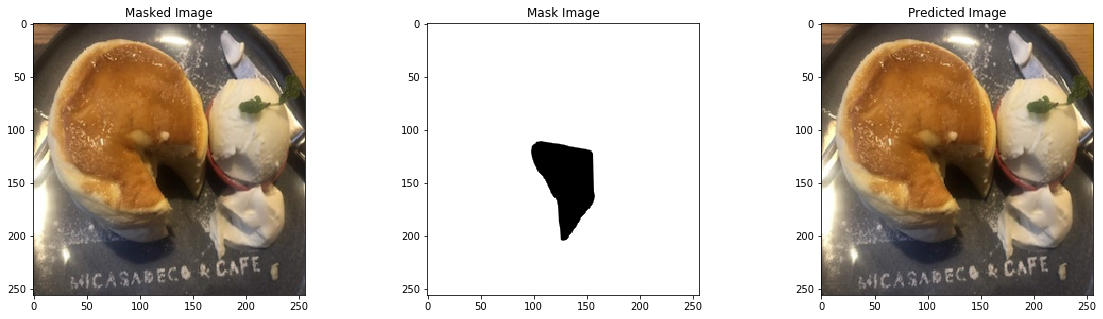

In [16]:
masked_img_path='/content/drive/My Drive/PConvC/data/pancake_images/pancakeR.bmp'
#masked_img_path='drive/My Drive/Colab Notebooks/data/food_images/q_10.bmp'

import skimage.io as ski_io
import skimage.color as ski_color
import skimage.morphology as ski_morph

masked = ski_io.imread(masked_img_path)
to_filling = (masked[:, :, 1] > 245) & (masked[:, :, 0] < 10) & (masked[:, :, 2] < 10)
mask_roi= np.zeros((256, 256, 3), np.uint8)
mask_roi[to_filling] = 1

#mask = 1.-mask_roi
mask = ski_io.imread('/content/drive/My Drive/PConvC/data/pancake_images/mask  pancake3.bmp')

erosion_size = 11
erosion_type = 0
val_type = cv2.MORPH_ELLIPSE
element = cv2.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
erosion_mask = cv2.erode(mask, element)

masked_tmp_list = []
masked_tmp_list.append(masked)
masked_na = np.array(masked_tmp_list)

mask_tmp_list = []
mask_tmp_list.append(erosion_mask)
mask_na = np.array(mask_tmp_list)

model = PConvUnet(weight_filepath='/content/drive/My Drive/PConvMC/data/logs(food101)')
#model.load('/content/drive/My Drive/PConvMC/data/logs(food101)/26_weights_2020-01-21-13-33-13.h5')
model.load('/content/drive/My Drive/PConvC/data/logs(food101)/511_weights_2020-01-29-15-36-56.h5')


pred_img_set = model.predict([masked_na, mask_na])

pred_img = 255.*pred_img_set[0,:,:,:]

gen_image = masked.copy()
gen_image[to_filling] = pred_img[to_filling]

   

_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[:,:,:])
axes[1].imshow(mask[:,:,:])
axes[2].imshow(pred_img[:,:,:])
axes[2].imshow(erosion_mask[:,:,:])
axes[2].imshow(gen_image[:,:,:])
axes[0].set_title('Masked Image')
axes[1].set_title('Mask Image')
axes[2].set_title('Predicted Image')
plt.show()

In [0]:
import pickle
fname = 'pancake_test2.pickle'
with open(fname,'wb') as f:
  pickle.dump(model,f)
  